In [51]:
import pickle
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding, Isomap, TSNE, MDS, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.cluster import DBSCAN, SpectralBiclustering

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
# ---------- User-tunable settings ----------
MIN_SAMPLES_PER_CELL = 4
PSEUDOCOUNT = 1e-6
DT = 1.0
EIG_K = 6
GRID_N = 50

def make_grid(xmin, xmax, ymin, ymax, nx=GRID_N, ny=GRID_N):
    x_edges = np.linspace(xmin, xmax, nx+1)
    y_edges = np.linspace(ymin, ymax, ny+1)
    return x_edges, y_edges

def map_to_cells(x, y, x_edges, y_edges):
    """
    Map arrays x,y to integer cell indices 0..(nx*ny-1).
    x,y can be 1D arrays or flattened.
    Returns cell_idx (int array)
    """
    xi = np.searchsorted(x_edges, x, side='right') - 1
    yi = np.searchsorted(y_edges, y, side='right') - 1
    # clip to edges
    xi = np.clip(xi, 0, len(x_edges)-2)
    yi = np.clip(yi, 0, len(y_edges)-2)
    return xi * (len(y_edges)-1) + yi  # cell index

def process_param_combo_2d(sim_generator, x_edges, y_edges, nx=GRID_N, ny=GRID_N):
    """
    sim_generator yields batches (X_batch, Y_batch) each shape (n_sims_batch, T)
    where X_batch and Y_batch contain floats (positions).
    Returns:
      density (M,), P (M x M row-stochastic), drift_u (M,), drift_v (M,), counts_per_cell (M,)
    """
    M = nx * ny
    counts = np.zeros(M, dtype=np.int64)
    trans_counts = np.zeros((M, M), dtype=np.int64)
    # For drift: accumulate sums and counts per cell (based on from-cell)
    drift_sum_u = np.zeros(M, dtype=np.float64)
    drift_sum_v = np.zeros(M, dtype=np.float64)
    drift_count = np.zeros(M, dtype=np.int64)

    for X_batch, Y_batch in sim_generator():
        # X_batch, Y_batch shapes: (n_sims, T)
        n_sims, T = X_batch.shape
        # flatten for counts
        flat_x = X_batch.ravel()
        flat_y = Y_batch.ravel()
        cell_idx_all = map_to_cells(flat_x, flat_y, x_edges, y_edges)
        counts += np.bincount(cell_idx_all, minlength=M)

        # transitions: from t to t+1
        x_from = X_batch[:, :-1].ravel()
        y_from = Y_batch[:, :-1].ravel()
        x_to   = X_batch[:, 1:].ravel()
        y_to   = Y_batch[:, 1:].ravel()
        from_idx = map_to_cells(x_from, y_from, x_edges, y_edges)
        to_idx   = map_to_cells(x_to, y_to, x_edges, y_edges)
        pair_idx = from_idx * M + to_idx
        pair_counts = np.bincount(pair_idx, minlength=M*M)
        trans_counts += pair_counts.reshape(M, M)

        # drift increments per from cell (u = dx/dt, v = dy/dt)
        u = (x_to - x_from) / DT
        v = (y_to - y_from) / DT
        # accumulate sums for each from cell
        # use bincount with weights
        for arr, out_sum in ((u, drift_sum_u), (v, drift_sum_v)):
            s = np.bincount(from_idx, weights=arr, minlength=M)
            out_sum += s
        drift_count += np.bincount(from_idx, minlength=M)

    total_counts = counts.sum()
    density = counts.astype(float) / (total_counts + 1e-30)

    # handle zero-row transitions: add tiny pseudocounts or replace with density-based fallback
    row_sums = trans_counts.sum(axis=1)
    zero_rows = (row_sums == 0)
    if zero_rows.any():
        # fallback: set row to density distribution (stochastic)
        trans_counts[zero_rows, :] = (density * 1_000).astype(np.int64) + 1
        row_sums = trans_counts.sum(axis=1)

    P = trans_counts.astype(float) / row_sums[:, None]
    # regularize small entries
    P = P + PSEUDOCOUNT
    P = P / P.sum(axis=1, keepdims=True)

    # drift averages, handle low counts
    drift_u = np.zeros(M, dtype=np.float64)
    drift_v = np.zeros(M, dtype=np.float64)
    mask = drift_count > 0
    drift_u[mask] = drift_sum_u[mask] / drift_count[mask]
    drift_v[mask] = drift_sum_v[mask] / drift_count[mask]

    # optionally set drift to NaN where counts < MIN_SAMPLES_PER_CELL
    low_mask = drift_count < MIN_SAMPLES_PER_CELL
    drift_u[low_mask] = 0.0
    drift_v[low_mask] = 0.0

    return density, P, drift_u, drift_v, counts

def spectral_features_from_P(P, k=EIG_K):
    # compute top-k eigenvalues and (right) eigenvectors of P
    M = P.shape[0]
    try:
        vals, vecs = eigs(P.T, k=k, which='LM')
        vals = vals.real
        vecs = vecs.real
        idx = np.argsort(-np.abs(vals))
        return vals[idx], vecs[:, idx]
    except Exception:
        from scipy.linalg import eig
        vals, vecs = eig(P.T)
        vals, vecs = vals.real, vecs.real
        idx = np.argsort(-np.abs(vals))
        vals = vals[idx][:k]
        vecs = vecs[:, idx][:, :k]
        return vals, vecs

def calculate_entropy(density):
    # Add a small constant to avoid log(0)
    return -np.sum(density * np.log(density + 1e-9))

def calculate_curl_and_divergence(du, dv, nx=GRID_N, ny=GRID_N):
    # Reshape drift vectors into a grid
    du_grid = du.reshape((nx, ny))
    dv_grid = dv.reshape((nx, ny))

    # Approximate gradients using np.gradient
    # Note: The dx, dy would be your grid spacing (cell width/height)
    # Here we assume unit spacing for simplicity
    dv_dx, _ = np.gradient(dv_grid)
    _, du_dy = np.gradient(du_grid)

    dudx, _ = np.gradient(du_grid)
    _, dvdy = np.gradient(dv_grid)

    # Curl = dv/dx - du/dy
    curl = dv_dx - du_dy
    
    # Divergence = du/dx + dv/dy
    divergence = dudx + dvdy

    return curl.ravel(), divergence.ravel()

In [4]:
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def sim_generator_from_pickle(path, batch_size=100):
    """
    Yields batches of (X_batch, Y_batch) from pickle file.
    Each batch is (n_sims_batch, T) arrays for wealth (X) and health (Y).
    """
    d = load_pickle(path)
    X_all = d['wealth']
    Y_all = d['health']
    n, T = X_all.shape
    for i in range(0, n, batch_size):
        yield X_all[i:i+batch_size], Y_all[i:i+batch_size]

In [5]:
model_dirs = {
    'A': 'results_5',
    'B': 'cpt_no_effect',
}

param_files = {
    model: sorted(glob(os.path.join(d, '*.pickle')))
    for model, d in model_dirs.items()
}

print("Model A files:", len(param_files['A']))
print("Model B files:", len(param_files['B']))

Model A files: 1024
Model B files: 1024


In [10]:
x_edges, y_edges = make_grid(1, 200, 1, 200, nx=GRID_N, ny=GRID_N)

for model in ['A', 'B']:
    model_features = []
    model_meta = []
    for idx, path in enumerate(tqdm(param_files[model], desc=f"Processing {model}")):
        sim_gen_fn = lambda: sim_generator_from_pickle(path, batch_size=100)

        # steady state density
        density, P, du, dv, counts = process_param_combo_2d(sim_gen_fn, x_edges, y_edges)

        # entropy
        entropy = calculate_entropy(density)

        # spectral features
        vals, vecs = spectral_features_from_P(P, k=6)
        non_stationary_vals = vals[1:6]
        real_parts = non_stationary_vals.real
        imag_parts = non_stationary_vals.imag
        if len(real_parts) < 5:
            real_parts = np.pad(real_parts, (0, 5 - len(real_parts)), 'constant')
            imag_parts = np.pad(imag_parts, (0, 5 - len(imag_parts)), 'constant')

        # curl and divergence
        curl, divergence = calculate_curl_and_divergence(du, dv)
        mean_curl = np.mean(np.abs(curl))
        max_curl = np.max(np.abs(curl))
        mean_divergence = np.mean(divergence)
        
        feat = np.concatenate([
            density,
            du,
            dv, 
            real_parts,
            imag_parts,
            [entropy, mean_curl, max_curl, mean_divergence]
        ])
        model_features.append(feat)
        model_meta.append({
            'model': model,
            'file': os.path.basename(path),
        })

    with open(f"embedding_meta_{model}", "wb") as f:
        pickle.dump(model_meta, f)

    with open(f"embedding_features_{model}", "wb") as f:
        pickle.dump(model_features, f)

Processing A:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing B:   0%|          | 0/1024 [00:00<?, ?it/s]

### Embedding + Projection

In [6]:
all_features = []
all_meta = []
param_values = []
for model in ["A", "B"]:
    with open(f"embedding_features_{model}", "rb") as f:
        all_features += pickle.load(f)
    with open(f"embedding_meta_{model}", "rb") as f:
        meta = pickle.load(f)
    all_meta += meta
    for row in tqdm(meta):
        with open(f"{model_dirs[model]}/{row['file']}", "rb") as f:
            D = pickle.load(f)["params"]
        param_values.append((
            D["alpha"], D["P_H_increase"], D["P_H_decrease"], D["w_delta_scale"], D["gamma"], D["omega"], D["eta"]
        ))

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

In [10]:
X_features = np.vstack(all_features)
print(X_features.shape)

(2048, 7514)


In [159]:
def embedding_comparison(with_pca, method):
    X_scaled = StandardScaler().fit_transform(X_features)

    if method == "pca":
        X_ = PCA(n_components=2).fit_transform(X_scaled)
    else:
        if with_pca:
            X_scaled = PCA(n_components=50).fit_transform(X_scaled)
        if method == "tsne":
            X_ = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(X_scaled)
        elif method == "spectral":
            X_ = SpectralEmbedding().fit_transform(X_scaled)
        elif method == "isomap":
            X_ = Isomap(n_neighbors=20).fit_transform(X_scaled)
        elif method == "lle":
            X_ = LocallyLinearEmbedding(n_neighbors=25, max_iter=450).fit_transform(X_scaled)

    plt.figure(figsize=(6,6))
    plt.scatter(X_[:1024,0], X_[:1024,1], alpha=0.5, c="crimson", label="CPT")
    plt.scatter(X_[1024:,0], X_[1024:,1], alpha=0.5, c="dodgerblue", label="PT")
    plt.legend()
    plt.show()

In [13]:
def embedding(model_name, with_pca, method, param_color_idx):
    if model_name == "A":
        X_scaled = StandardScaler().fit_transform(X_features[:1024])
        c = [x[param_color_idx] for x in param_values[:1024]]
    else:
        X_scaled = StandardScaler().fit_transform(X_features[1024:])
        c = [x[param_color_idx] for x in param_values[1024:]]

    if with_pca:
        X_scaled = PCA(n_components=50).fit_transform(X_scaled)

    if method == "tsne":
        X_ = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(X_scaled)
    elif method == "spectral":
        X_ = SpectralEmbedding().fit_transform(X_scaled)
    elif method == "isomap":
        X_ = Isomap(n_neighbors=5).fit_transform(X_scaled)

    plt.figure(figsize=(6,6))
    plt.scatter(X_[:,0], X_[:,1], alpha=0.7, c=c, cmap="viridis")
    plt.title(model_dirs[model_name])
    plt.show()

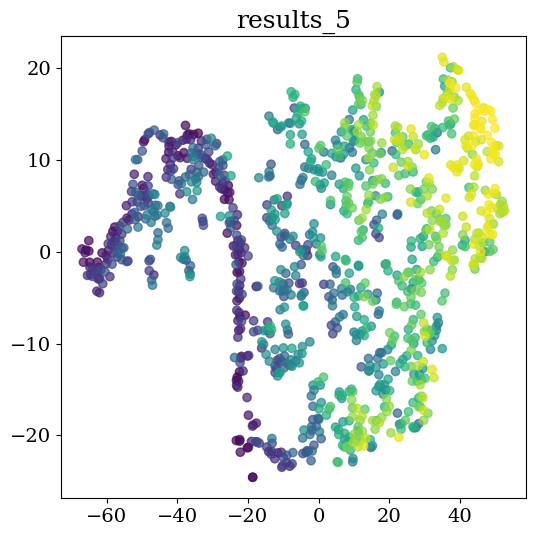

In [257]:
embedding("A", True, "tsne", 0)

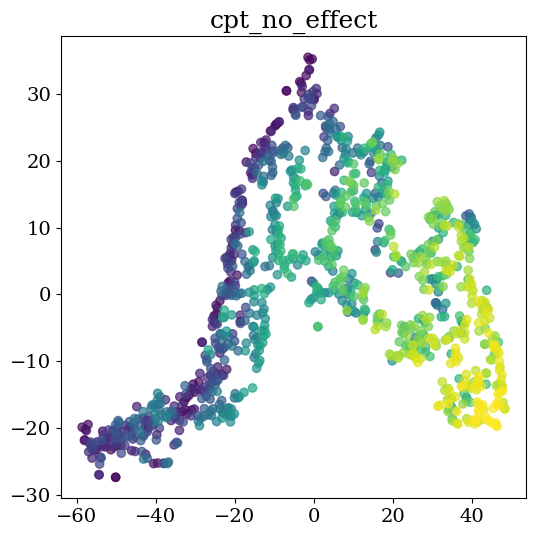

In [258]:
embedding("B", True, "tsne", 0)

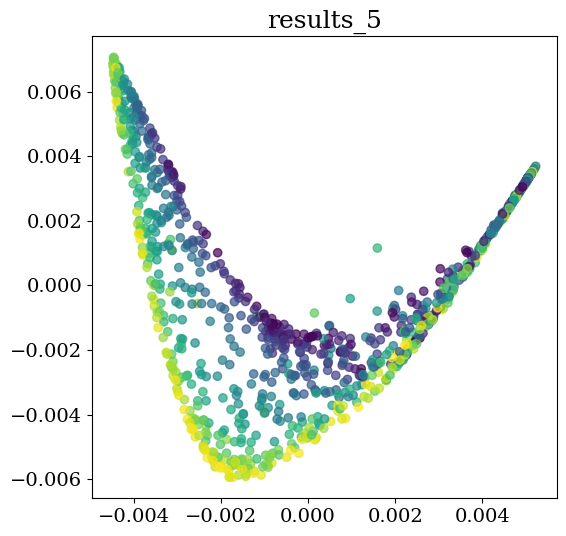

In [261]:
embedding("A", False, "spectral", 2)

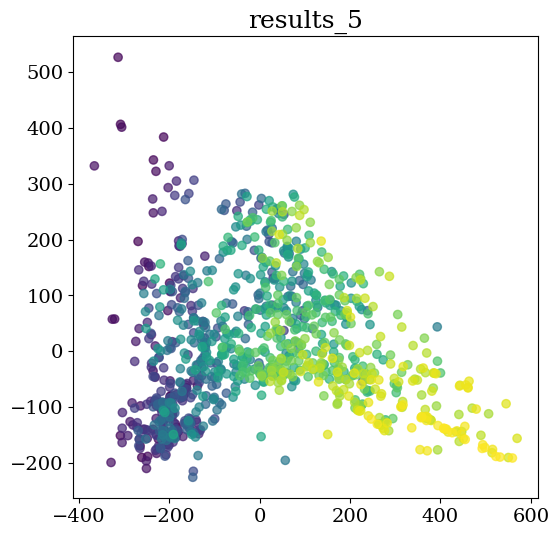

In [264]:
embedding("A", False, "isomap", 0)

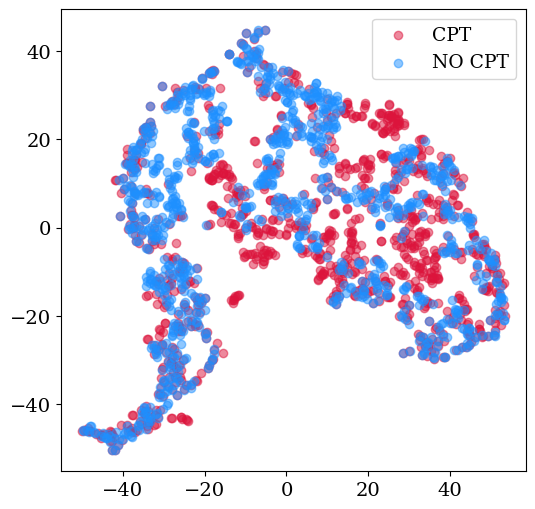

In [160]:
embedding_comparison(True, "tsne")

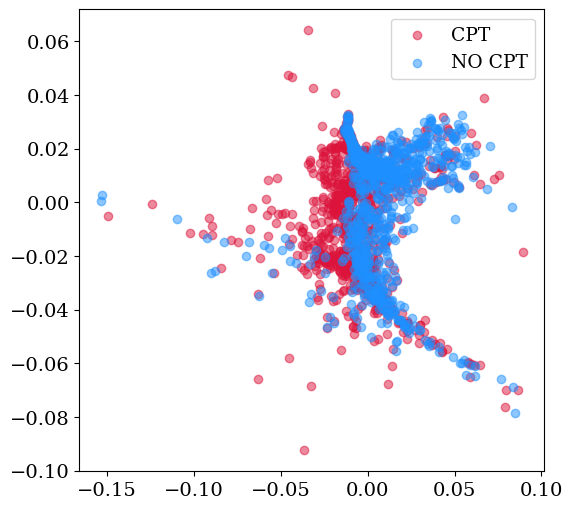

In [149]:
embedding_comparison(True, "lle")